# Stock analysis

## Import

Libraries

In [1]:
from functions.init import *

from functions.analyse_price import *
from functions.analyse_fundementals import *
from functions.params import index_tickers

In [2]:
TICKER = 'NVX'
first_end_of_quarter = '2020-06'
last_end_of_quarter = '2024-06'
historical_prices = {}

## Get data

Run data

In [3]:
AU_interest_rate = pd.read_csv(
    '../data/Australia 10-Year Bond Yield Historical Data.csv')

AU_interest_rate['rf (%)'] = AU_interest_rate['Price'].shift(-1)

AU_interest_rate = AU_interest_rate.dropna()
AU_interest_rate = AU_interest_rate[['Date', 'rf (%)']]

AU_interest_rate['Date'] = pd.to_datetime(
    AU_interest_rate['Date'], dayfirst=True)

AU_interest_rate_monthly = copy.deepcopy(AU_interest_rate)
AU_interest_rate_monthly['rf (%)'] = AU_interest_rate_monthly['rf (%)'].apply(
    lambda x: np.power(1+x, 1/12)-1)

AU_interest_rate_quarterly = AU_interest_rate[AU_interest_rate['Date'].dt.month.isin([
                                                                                     1, 4, 7, 10])]
AU_interest_rate_quarterly['rf (%)'] = AU_interest_rate_quarterly['rf (%)'].apply(
    lambda x: np.power(1+x, 3/12)-1)
AU_interest_rate_annualy = AU_interest_rate[AU_interest_rate['Date'].dt.month.isin([
                                                                                   1])]

AU_interest_rate_monthly = AU_interest_rate_monthly.set_index('Date')
AU_interest_rate_quarterly = AU_interest_rate_quarterly.set_index('Date')
AU_interest_rate_annualy = AU_interest_rate_annualy.set_index('Date')

In [4]:
asx_companies_directory = pd.read_csv('../data/asx_companies_directory.csv')
asx_companies_directory['Market Cap'] = asx_companies_directory['Market Cap'].apply(
    lambda x: float(x) if x.isnumeric() else float(x.lower()) if 'E+' in x else np.nan)

In [5]:
gics = pd.read_csv('../data/asx_gics.csv')

# Define a dictionary mapping tickers to their corresponding sector and industry
updates = {
    'NWSLV.AX': {'Sector': 'Communication Services', 'Industry': 'Entertainment'},
    'KKC.AX': {'Sector': 'Financials', 'Industry': 'Diversified Financials'},
    'PCI.AX': {'Sector': 'Financials', 'Industry': 'Diversified Financials'},
    'RF1.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'},
    'RG8.AX': {'Sector': 'Information Technology', 'Industry': 'Software'},
    'VG1.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'},
    'WQG.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'}
}

# Update the DataFrame based on the mapping
for ticker, data in updates.items():
    gics.loc[gics['Ticker'] == ticker, 'Sector'] = data['Sector']
    gics.loc[gics['Ticker'] == ticker, 'Industry'] = data['Industry']


gics['Industry'] = gics['Industry'].apply(lambda x: ''.join(
    str(x).split('-')).replace(' ', '').replace('—', ''))

gics['Sector'] = gics['Sector'].apply(lambda x: ''.join(
    str(x).split('-')).replace(' ', '').replace('—', ''))

In [6]:
# all companies in the top 500
top_500 = asx_companies_directory.sort_values(
    'Market Cap', ascending=False).head(500)['ASX code'].values + '.AX'

# get all companies with market cap above 1 billion
above_1b = asx_companies_directory[asx_companies_directory['Market Cap']
                                   >= 1000000000]['ASX code'].values + '.AX'

In [7]:
def find_similar_type_tickers(gics_type: str, gics_name: str, comparable_universe: list) -> list:
    same_gics_tickers = gics[(gics[gics_type] == gics_name) & (
        gics['Ticker'].isin(comparable_universe))]['Ticker'].values

    return same_gics_tickers

In [8]:
# find same industry stocks
ticker_gics_sector = gics[gics['Ticker'] == f'{TICKER}.AX']['Sector'].values[0]
ticker_gics_industry = gics[gics['Ticker']
                            == f'{TICKER}.AX']['Industry'].values[0]

In [9]:
same_sector_1bn = find_similar_type_tickers(
    gics_type='Sector', gics_name=ticker_gics_sector, comparable_universe=above_1b)
same_industry_1bn = find_similar_type_tickers(
    gics_type='Industry', gics_name=ticker_gics_industry, comparable_universe=above_1b)
same_sector_500 = find_similar_type_tickers(
    gics_type='Sector', gics_name=ticker_gics_sector, comparable_universe=top_500)
same_industry_500 = find_similar_type_tickers(
    gics_type='Industry', gics_name=ticker_gics_industry, comparable_universe=top_500)

In [10]:
comparable_tickers = {'type': 'same_industry_500', 'list': same_industry_500} if \
    (len(same_industry_500) > 1 or len(same_industry_500) == 1 and f'{TICKER}.AX' not in same_industry_500) \
    else {'type': 'same_sector_1bn', 'list': same_sector_1bn}

# remove self from comparable_tickers
comparable_tickers['list'] = [
    x for x in comparable_tickers['list'] if x != f'{TICKER}.AX']

In [11]:
comparable_tickers['type']

'same_sector_1bn'

In [12]:
# get market caps and weight
same_industry_tickers_mcap = asx_companies_directory[((asx_companies_directory['ASX code']+'.AX').isin(
    comparable_tickers['list'])) & (asx_companies_directory['ASX code'] != TICKER)][['ASX code', 'Market Cap']]

# check for is integer
marketsame_industry_tickers_mcap_cap = same_industry_tickers_mcap[same_industry_tickers_mcap['Market Cap'].apply(
    lambda x: isinstance(x, float))]

# get weight
same_industry_tickers_mcap['weight'] = same_industry_tickers_mcap['Market Cap'] / \
    same_industry_tickers_mcap['Market Cap'].sum()

In [13]:
same_industry_tickers_mcap = same_industry_tickers_mcap.sort_values(
    by='Market Cap', ascending=False)
display(same_industry_tickers_mcap)

ticker_mv = asx_companies_directory[asx_companies_directory['ASX code'] == TICKER][[
    'ASX code', 'Market Cap']]
display(ticker_mv)

ticker_proportion_of_market = ticker_mv['Market Cap'].values[0] / \
    same_industry_tickers_mcap['Market Cap'].sum()
print(round(ticker_proportion_of_market, 2))

,ASX code,Market Cap,weight
1723,TCL,4.093633e+10,0.204927
358,BXB,2.640665e+10,0.132192
1493,REH,1.786792e+10,0.089447
1699,SVW,1.746022e+10,0.087406
96,AIA,1.117357e+10,0.055935
1454,QAN,1.089885e+10,0.054560
909,IFT,1.070929e+10,0.053611
123,ALX,7.007527e+09,0.035080
120,ALQ,6.919700e+09,0.034640
1464,QUB,6.914100e+09,0.034612


,ASX code,Market Cap
1274,NVX,357968369.0


0.0


In [14]:
ticker_mv['Market Cap'] = ticker_mv['Market Cap'].apply(
    lambda x: round(x/1e9, 2))
ticker_mv.rename(columns={'Market Cap': 'Market Cap ($bn)'}, inplace=True)

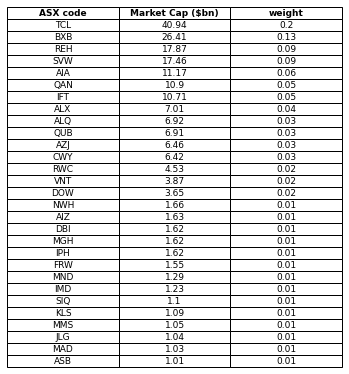

In [15]:
# Create the plot
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust figure size as needed
ax.axis('tight')
ax.axis('off')

same_industry_tickers_mcap['Market Cap'] = same_industry_tickers_mcap['Market Cap'].apply(
    lambda x: round(x/1e9, 2))
same_industry_tickers_mcap.rename(
    columns={'Market Cap': 'Market Cap ($bn)'}, inplace=True)
same_industry_tickers_mcap['weight'] = same_industry_tickers_mcap['weight'].apply(
    lambda x: round(x, 2))


# Create a table in the plot
table = ax.table(cellText=same_industry_tickers_mcap.values,
                 colLabels=same_industry_tickers_mcap.columns,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')


# Save the plot as an image
plt.savefig(f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [16]:
same_gics_industry_weight_dict = same_industry_tickers_mcap.set_index('ASX code')[
    'weight'].to_dict()

In [17]:
my_portfolio_tickers = [TICKER]
my_portfolio_tickers.extend([ticker.split('.')[
                            0] for ticker in comparable_tickers['list'] if ticker.split('.')[0] != TICKER])
my_portfolio_tickers.extend(index_tickers)

historical_prices = get_historical_prices(
    my_portfolio_tickers, index_tickers, historical_prices)

$DBI.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$FRW.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$MGH.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$FRW.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")
$FRW.AX: possibly delisted; no price data found  (1d 2021-01-01 -> 2021-12-31) (Yahoo error = "Data doesn't exist for startDate = 1609419600, endDate = 1640869200")
$VNT.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$FRW.AX: p

In [18]:
def get_return(price_df: pd.DataFrame, interest_rate: pd.DataFrame, interval: str = "M") -> pd.DataFrame:
    """
    Get return of stock on a specified interval basis (last close price/last close price previous period - 1)

    Parameters:
    - price_df: pd.DataFrame - DataFrame with stock prices (must have a 'Close' column and a DateTime index)
    - interest_rate: pd.DataFrame - DataFrame with interest rates
    - interval: str - Resampling interval ('M' for monthly, 'Q' for quarterly, 'Y' for yearly)

    Returns:
    - pd.DataFrame with stock returns and interest rate for each period
    """
    assert interval in ["M", "Q", "Y"], "interval must be M, Q or Y"

    # Ensure the index is a DatetimeIndex
    price_df.index = pd.to_datetime(price_df.index)

    # Resample to get the last close price of each period
    last_close_price = price_df.resample(interval).last()

    # Calculate the return
    return_series = last_close_price["Close"].pct_change() * 100
    return_series = return_series.to_frame(name=f"{interval}_Return (%)")

    # Format the index to display period correctly
    if interval == "Y":
        return_series.index = return_series.index.to_period("Y").strftime("%Y")
        return_series['merge_use_Y-M'] = return_series.index

        interest_rate['merge_use_Y-M'] = interest_rate.index.to_period(
            "Y").strftime("%Y")

    elif interval == "Q":
        return_series.index = return_series.index.to_period(
            "Q").strftime("%Y-Q%q")
        return_series['merge_use_Y-M'] = return_series.index

        interest_rate['merge_use_Y-M'] = interest_rate.index.to_period(
            "Q").strftime("%Y-Q%q")

    else:
        return_series.index = return_series.index.to_period(
            "M").strftime("%Y-%m")
        return_series['merge_use_Y-M'] = return_series.index

        interest_rate['merge_use_Y-M'] = interest_rate.index.to_period(
            "M").strftime("%Y-%m")

    return_series = return_series.merge(
        interest_rate, on='merge_use_Y-M', how="left").set_index(return_series.index)

    return_series.drop(columns='merge_use_Y-M', inplace=True)

    return_series[f"{interval}_Return - rf (%)"] = return_series[f"{interval}_Return (%)"] - \
        return_series['rf (%)']

    return return_series

In [19]:
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    monthly_returns_df_dict[ticker] = get_return(
        price_df, AU_interest_rate_monthly, 'M')

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    quarterly_returns_df_dict[ticker] = get_return(
        price_df, AU_interest_rate_quarterly, 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    yearly_returns_df_dict[ticker] = get_return(
        price_df, AU_interest_rate_annualy, 'Y')

In [20]:
monthly_returns_df_dict = get_gics_industry_weighted_mean(
    monthly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'M', comparable_tickers=comparable_tickers)
quarterly_returns_df_dict = get_gics_industry_weighted_mean(
    quarterly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'Q', comparable_tickers=comparable_tickers)
yearly_returns_df_dict = get_gics_industry_weighted_mean(
    yearly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'Y', comparable_tickers=comparable_tickers)

In [21]:
get_stats(monthly_returns_df_dict, TICKER,
          first_end_of_quarter, last_end_of_quarter)

{'mean (%)': 5.67,
 'std (%)': 34.51,
 'mean (-rf) (%)': 5.56,
 'std (-rf) (%)': 34.53,
 'n': 49,
 'sharpe': 0.56,
 'CAPM beta': 2.34,
 'CAPM alpha': 4.63}

In [22]:
stats_dict = {}

for ticker in monthly_returns_df_dict:
    stats_dict[ticker] = get_stats(
        monthly_returns_df_dict, ticker, first_end_of_quarter, last_end_of_quarter)

stats_df = pd.DataFrame(stats_dict).T

In [23]:
same_gics_stats_df = stats_df[~stats_df.index.isin(
    index_tickers + [TICKER, 'GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean'])]

In [24]:
same_gics_stats_df['ASX code'] = same_gics_stats_df.index

same_gics_stats_df = same_gics_stats_df.merge(
    same_industry_tickers_mcap, on='ASX code')

In [25]:
# get weighted means of each column
weighted_mean_dict = {}
for col in same_gics_stats_df.columns:
    if col in ['ASX code', 'weight']:
        continue
    weighted_mean_dict[col] = np.average(
        same_gics_stats_df[col], weights=same_gics_stats_df['weight'])

weighted_mean_df = pd.DataFrame(weighted_mean_dict, index=[
                                'GICS I.WMean (Macro)' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean (Macro)'])
weighted_mean_df

stats_df = pd.concat(
    [stats_df, weighted_mean_df.drop(columns=['Market Cap ($bn)'])])
stats_df

,mean (%),std (%),mean (-rf) (%),std (-rf) (%),n,sharpe,CAPM beta,CAPM alpha
NVX,5.670000,34.510000,5.560000,34.530000,49.000000,0.560000,2.340000,4.63000
AIA,0.480000,5.200000,0.370000,5.210000,49.000000,0.250000,1.060000,-0.74000
AIZ,-0.450000,8.370000,-0.560000,8.370000,49.000000,-0.230000,1.830000,-1.39000
ALQ,1.950000,8.220000,1.840000,8.230000,49.000000,0.770000,1.450000,1.01000
ALX,0.230000,5.800000,0.120000,5.800000,49.000000,0.070000,0.880000,-0.31000
ASB,0.200000,11.000000,0.090000,10.990000,49.000000,0.030000,0.860000,0.25000
AZJ,0.080000,5.460000,-0.030000,5.450000,49.000000,-0.020000,0.670000,-0.43000
BXB,0.840000,5.750000,0.730000,5.740000,49.000000,0.440000,0.660000,0.64000
CWY,1.220000,8.670000,1.110000,8.680000,49.000000,0.440000,1.170000,0.33000
DBI,1.540000,4.220000,1.420000,4.220000,42.000000,1.170000,0.450000,1.42000


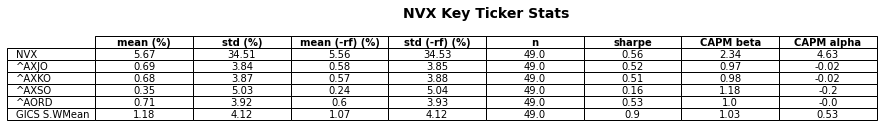

In [26]:
# Assuming key_ticker_stats is already created from your DataFrame
key_ticker_stats = stats_df.loc[[TICKER, '^AXJO',
                                 '^AXKO', '^AXSO', '^AORD'] + ['GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean']]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 2))  # Adjust figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=key_ticker_stats.values,
                 colLabels=key_ticker_stats.columns,
                 rowLabels=key_ticker_stats.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Ticker Stats", fontsize=14, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_key_ticker_stats_table.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [27]:
ticker_mv['Market Cap ($bn)'].values[0] / \
    weighted_mean_df['Market Cap ($bn)'].values[0]

0.020531788834870817

In [28]:
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, first_end_of_quarter, last_end_of_quarter)

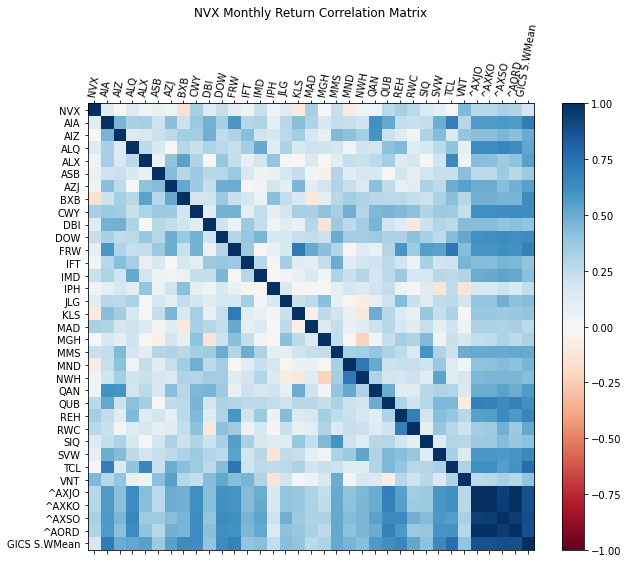

In [29]:
plot_correlation(correlation_df, ticker=TICKER)

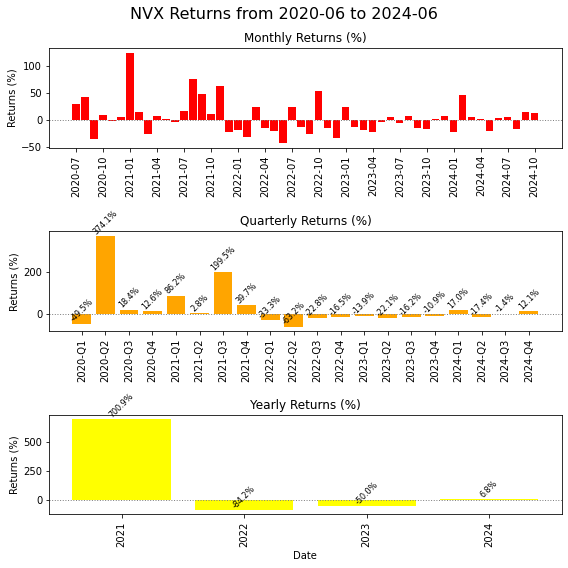

In [30]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': TICKER,
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

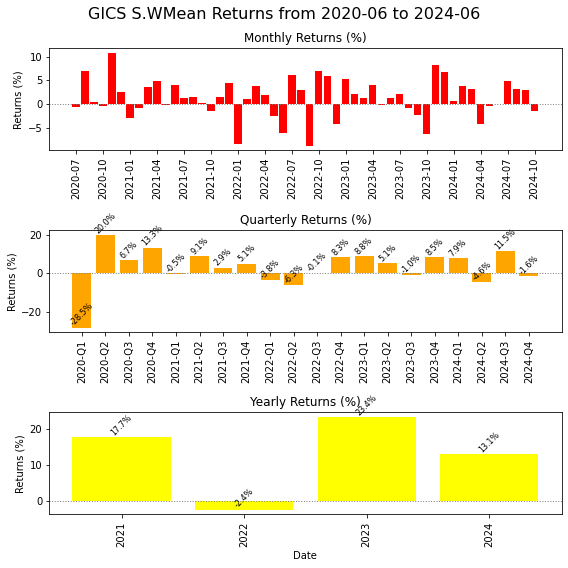

In [31]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict,
                'ticker': 'GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter,
                'underlying_ticker': TICKER})

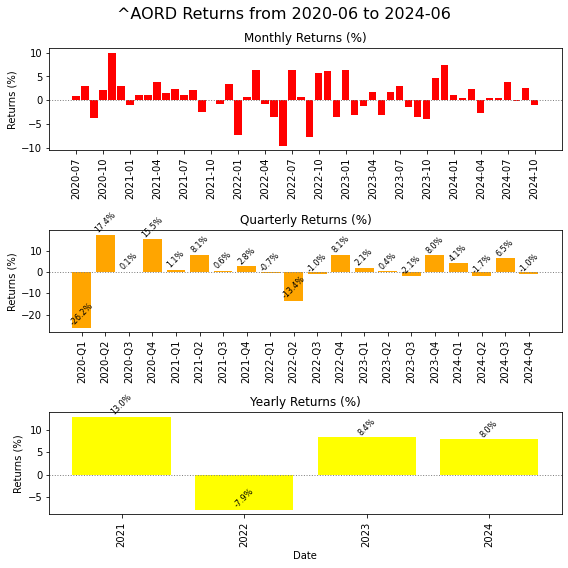

In [32]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': '^AORD',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

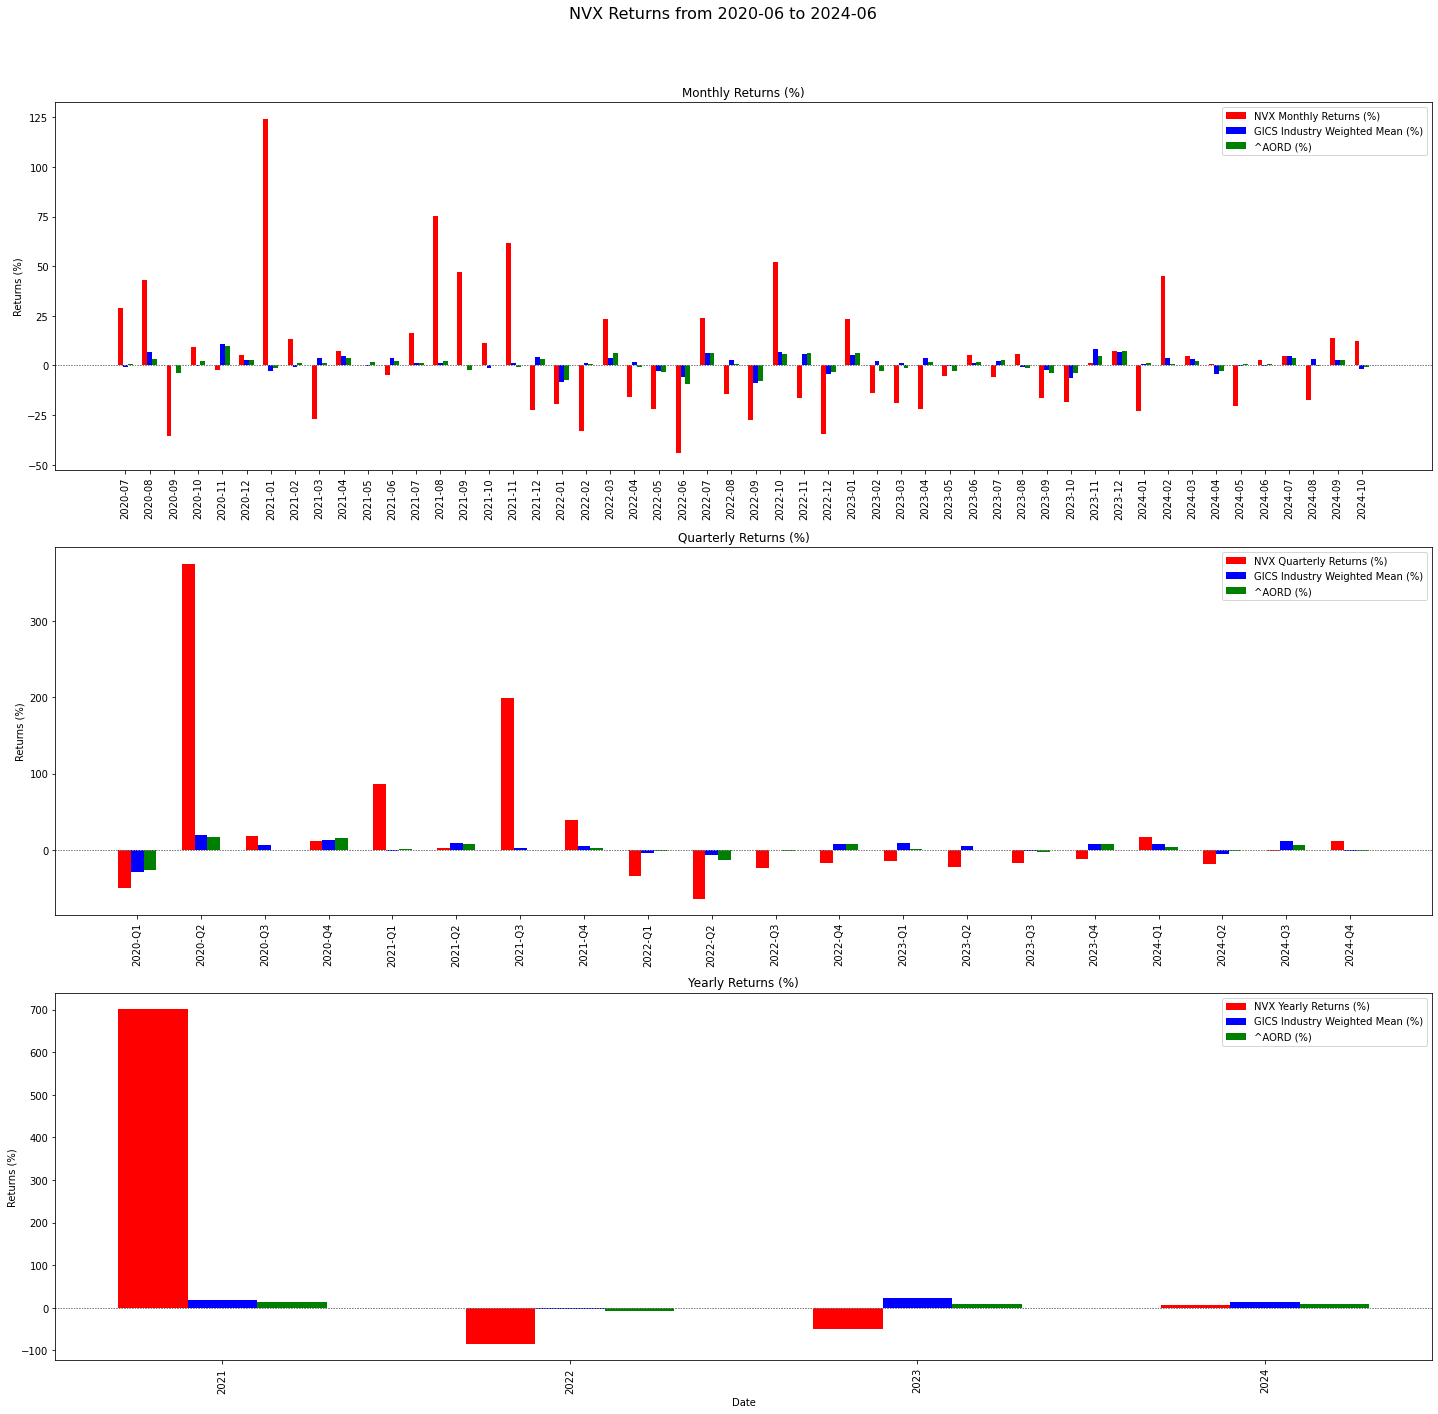

In [33]:
plot_returns_comparative(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                            'quarterly_returns_df_dict': quarterly_returns_df_dict,
                            'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER,
                            'first_end_of_quarter': first_end_of_quarter,
                            'last_end_of_quarter': last_end_of_quarter,
                            'comparable_tickers': comparable_tickers})

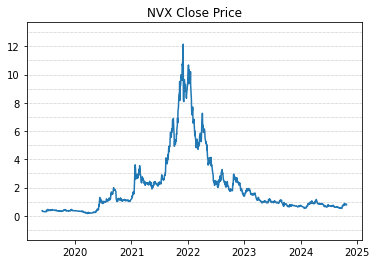

In [34]:
plot_close_price_with_dollar_lines(TICKER, historical_prices)

In [35]:
# Convert date to AEST directly using tz_convert, since the index is already timezone-aware
historical_dividends = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()

# Ensure the 'Date' column is in datetime format
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])

# Convert the 'Date' column to AEST
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone unaware but still a timestamp
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Display the dividends greater than 0 with the adjusted 'Date' column
display(historical_dividends[historical_dividends['Dividends'] > 0][[
        'Date', 'Dividends']])

,Date,Dividends


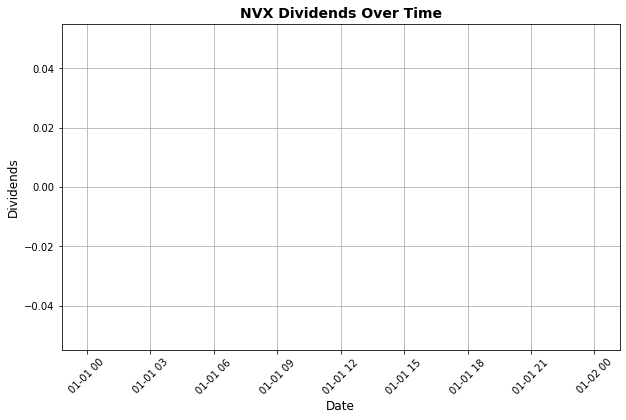

In [36]:
# Assuming historical_dividends is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_dividends = historical_prices[TICKER]
# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Filter the data to include only the rows where Dividends are greater than 0
dividends_df = historical_dividends[historical_dividends['Dividends'] > 0][[
    'Date', 'Dividends']]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Dividends
ax.plot(dividends_df['Date'], dividends_df['Dividends'],
        marker='o', linestyle='-', color='b')

# Set the title and labels
ax.set_title(f'{TICKER} Dividends Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Dividends', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax.grid(True)

# Save the plot as an image if needed
plt.savefig(f'../outputs/{TICKER}_dividends_over_time.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

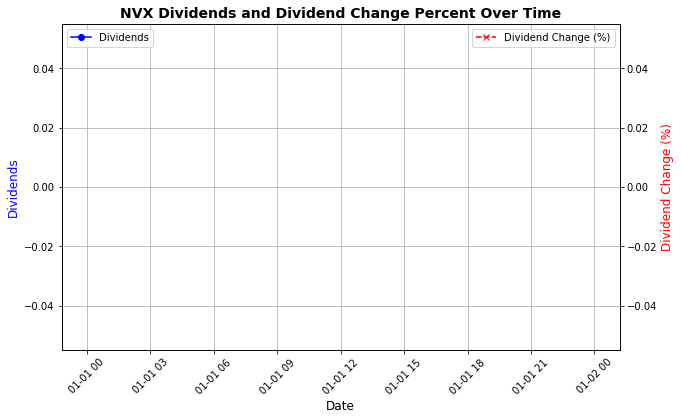

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming historical_dividends is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_dividends = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Filter the data to include only the rows where Dividends are greater than 0
dividends_df = historical_dividends[historical_dividends['Dividends'] > 0][[
    'Date', 'Dividends']]

# Calculate the percentage change in dividends
dividends_df['Dividend Change (%)'] = dividends_df['Dividends'].pct_change(
) * 100

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Dividends on the primary y-axis
ax1.plot(dividends_df['Date'], dividends_df['Dividends'],
         marker='o', linestyle='-', color='b', label='Dividends')

# Set the title and labels for the primary y-axis
ax1.set_title(f'{TICKER} Dividends and Dividend Change Percent Over Time',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Dividends', fontsize=12, color='b')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax1.grid(True)

# Create a secondary y-axis to plot the dividend change percentage
ax2 = ax1.twinx()

# Plot Date vs Dividend Change (%) on the secondary y-axis
ax2.plot(dividends_df['Date'], dividends_df['Dividend Change (%)'],
         marker='x', linestyle='--', color='r', label='Dividend Change (%)')

# Set the labels for the secondary y-axis
ax2.set_ylabel('Dividend Change (%)', fontsize=12, color='r')

# Add legends to distinguish between the two y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Annotate the percentage change values on the plot
for i, (date, change) in dividends_df[['Date', 'Dividend Change (%)']].dropna().iterrows():
    ax2.annotate(f'{change:.1f}%', xy=(date, change), xytext=(5, 5),
                 textcoords='offset points', fontsize=10, color='r')

# Save the plot as an image if needed
plt.savefig(
    f'../outputs/{TICKER}_dividends_and_change_over_time.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [38]:
# Convert date to AEST directly using tz_convert, since the index is already timezone-aware
historical_splits = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_splits = historical_splits.reset_index()

# Ensure the 'Date' column is in datetime format
historical_splits['Date'] = pd.to_datetime(historical_splits['Date'])

# Convert the 'Date' column to AEST
historical_splits['Date'] = historical_splits['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone unaware but still a timestamp
historical_splits['Date'] = historical_splits['Date'].dt.tz_localize(
    None)

# Display the dividends greater than 0 with the adjusted 'Date' column
display(historical_splits[historical_splits['Stock Splits'] > 0][[
        'Date', 'Stock Splits']])

,Date,Stock Splits


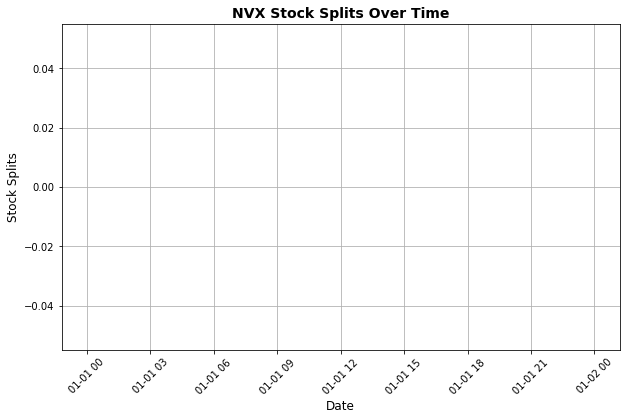

In [39]:
# Assuming historical_splits is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_splits = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_splits = historical_splits.reset_index()

# Ensure the 'Date' column is in datetime format
historical_splits['Date'] = pd.to_datetime(historical_splits['Date'])

# Convert the 'Date' column to AEST
historical_splits['Date'] = historical_splits['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone-unaware but still a timestamp
historical_splits['Date'] = historical_splits['Date'].dt.tz_localize(None)

# Filter the data to include only the rows where Stock Splits are greater than 0
splits_df = historical_splits[historical_splits['Stock Splits'] > 0][[
    'Date', 'Stock Splits']]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Stock Splits
ax.plot(splits_df['Date'], splits_df['Stock Splits'],
        marker='o', linestyle='-', color='b')

# Set the title and labels
ax.set_title(f'{TICKER} Stock Splits Over Time',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Stock Splits', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax.grid(True)

# Save the plot as an image if needed
plt.savefig(f'../outputs/{TICKER}_stock_splits_over_time.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [40]:
# pdf = FPDF()

# # TITLE
# # Add a page
# pdf.add_page()
# # Set font for the title
# pdf.set_font("Arial", 'B', 16)  # Bold and size 16 for the title
# title = f"Stock Analysis of Ticker: {TICKER}"
# pdf.cell(200, 10, txt=title, ln=True, align='C')

# # Comparable Ticker Universe
# # Set font for the content
# pdf.set_font("Arial", 'B', size=12)
# pdf.cell(200, 10, txt=f"Comparable tickers universe", ln=True, align='L')
# pdf.set_font("Arial", size=10)
# text = f"{'same INDUSTRY of TOP500' if 'industry' in comparable_tickers['type'] else 'same SECTOR of MCAP$1BN+'}"
# pdf.cell(200, 10, txt=text, ln=True, align='L')

# # Retrieve and convert the Market Cap of the stock in question (from ticker_mv) to billions
# ticker_market_cap_billion = round(
#     ticker_mv.iloc[0]['Market Cap ($bn)'], 2)
# ticker_proportion_of_market = ticker_mv['Market Cap ($bn)'].values[0] / \
#     same_industry_tickers_mcap['Market Cap ($bn)'].sum()
# universe_market_value_billion = round(
#     same_industry_tickers_mcap['Market Cap ($bn)'].sum(), 2)
# pdf.cell(
#     200, 10, txt=f"{TICKER} has a market value of ${ticker_market_cap_billion}B and is {round(ticker_proportion_of_market, 2)} times the universe market value of ${universe_market_value_billion}B,", align='L')
# pdf.cell(
#     200, 10, txt=f"{round(ticker_mv['Market Cap ($bn)'].values[0]/weighted_mean_df['Market Cap ($bn)'].values[0],2)} times the average stock MCap in the universe.", align='L')
# pdf.ln()

# # KEY STATS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Key Stats", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_key_ticker_stats_table.png', x=10, y=None, w=125)

# # COMPARATIVE RETURNS PLOTS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Comparative Returns Plot", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_comparative_returns.png', x=10, y=None, w=150)

# # TICKER RETURN CHART
# pdf.add_page()  # Add a new page for the plot
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Returns Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_returns.png', x=10, y=None, w=100)

# # SECTOR/INDUSTRY WMEAN RETURNS CHART
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(
#     200, 10, txt=f"{TICKER} {'Industry' if 'industry' in comparable_tickers['type'] else 'Sector'} Weighted Mean Returns Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_WMean_returns.png', x=10, y=None, w=100)

# # ^AORD CHART
# pdf.add_page()
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(
#     200, 10, txt=f"{TICKER} ^AORD Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/^AORD_returns.png', x=10, y=None, w=100)

# # CLOSE PRICE CHART
# pdf.add_page()  # Add a new page for the plot
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Close Price Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_close_price.png', x=10, y=None, w=75)

# # DIVIDENDS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Dividends", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_dividends_over_time.png', x=10, y=None, w=75)

# # APPENDIX
# pdf.add_page()  # Add a new page for the appendix
# # Set font for the title
# pdf.set_font("Arial", 'B', 12)  # Bold and size 16 for the title

# # APPENDIX TITLE
# title = f"Appendix"
# pdf.cell(200, 10, txt=title, ln=True, align='C')

# # CORRELATION
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(200, 10, txt=f"{TICKER} Correlation Matrix Plot", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_correlation_matrix.png', x=10, y=None, w=140)

# # SPLITS
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(200, 10, txt=f"{TICKER} Splits", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_stock_splits_over_time.png', x=10, y=None, w=75)

# # INDUSTRY TICKER MCAP TABLE
# pdf.add_page()
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(
#     200, 10, txt=f"{TICKER} Same {'Industry' if 'industry' in comparable_tickers['type'] else 'Sector'} Ticker MCAP Table", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png', x=10, y=None, w=75)

# # Save the PDF after adding the image
# pdf.output(f"../reports/{TICKER}_comparable_tickers_report_with_plot.pdf")

# Other Stats

In [41]:
interested_ticker_raw_stats, interested_ticker_key_interested_stats, interested_ticker_key_interested_stats_pct_change, object = get_fundemental_dfs(
    first_end_of_quarter, historical_prices, TICKER)

Income Tax Paid Supplemental Data not found for ticker NVX: 'Income Tax Paid Supplemental Data'
Missing data for Net Profit for ticker NVX: 'Income Tax Paid Supplemental Data'


In [42]:
interested_ticker_raw_stats

,Total Debt,Stockholders Equity,Share Issued,Current Liabilities,Current Assets,Free Cash Flow,Interest Paid Supplemental Data,EBITDA,EBIT,Gross Profit,Operating Expense,Net Income,Total Revenue,Interest Expense,Net Profit,Average Shareholder Equity,Total Asset,Last Close Price,Dividends
2020-06-30,NaN,NaN,NaN,NaN,NaN,-7426208.0,232055.0,-9889331.0,-11072623.0,2016403.0,11480306.0,-13430174.0,2851035.0,2357551.0,NaN,NaN,NaN,0.870,NaN
2021-06-30,10356322.0,138449834.0,404601384.0,4019887.0,108227852.0,-25664712.0,227789.0,-12041303.0,-13305925.0,3083075.0,14332336.0,-13446593.0,3893739.0,140668.0,NaN,138449834.0,142469721.0,2.220,0.0
2022-06-30,42309006.0,251133478.0,485951369.0,7890475.0,162223451.0,-113019442.0,NaN,-46177118.0,-50391738.0,4376530.0,52419783.0,-51860307.0,6101155.0,1468569.0,NaN,194791656.0,259023953.0,2.280,0.0
2022-12-31,41341840.0,226056269.0,486774622.0,8465141.0,116148207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238594873.5,234521410.0,1.470,0.0
2023-12-31,69387750.0,183936275.0,488733461.0,7840362.0,89153275.0,-55424219.0,NaN,-38862526.0,-43602661.0,5237259.0,53465364.0,-46248261.0,8054528.0,2845549.0,NaN,204996272.0,191776637.0,0.735,0.0


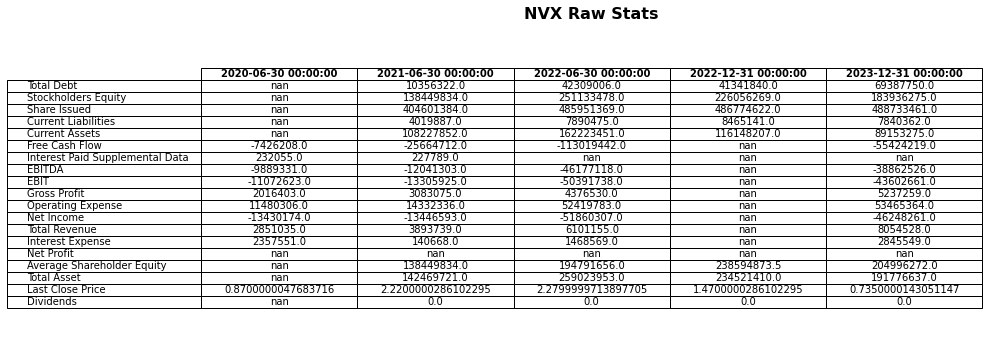

In [43]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(14, 6))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=interested_ticker_raw_stats.T.values,
                 colLabels=interested_ticker_raw_stats.T.columns,
                 rowLabels=interested_ticker_raw_stats.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Raw Stats", fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_interested_ticker_raw_stats.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [44]:
interested_ticker_key_interested_stats

,Net Profit Margin,Net Income Margin,RoE,RoA,P/E,P/B,D/E,Current Ratio,Interest Coverage Ratio,DPS
2020-06-30,NaN,-4.71,NaN,NaN,NaN,NaN,NaN,NaN,-47.72,NaN
2021-06-30,NaN,-3.45,NaN,NaN,-66.80,6.49,0.07,26.92,-58.41,0.0
2022-06-30,NaN,-8.50,NaN,NaN,-21.36,4.41,0.17,20.56,NaN,0.0
2022-12-31,NaN,NaN,NaN,NaN,NaN,3.17,0.18,13.72,NaN,0.0
2023-12-31,NaN,-5.74,NaN,NaN,-7.77,1.95,0.38,11.37,NaN,0.0


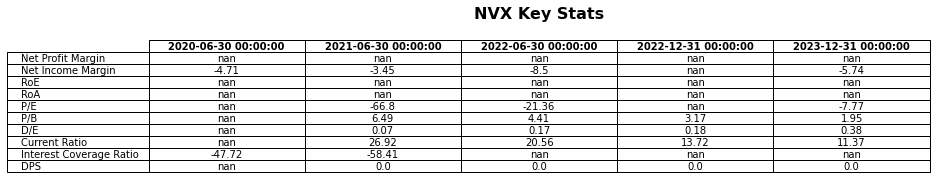

In [45]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(14, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=interested_ticker_key_interested_stats.T.values,
                 colLabels=interested_ticker_key_interested_stats.T.columns,
                 rowLabels=interested_ticker_key_interested_stats.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Stats", fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_interested_ticker_key_interested_stats.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [46]:
interested_ticker_key_interested_stats_pct_change

,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,-26.69,NaN,NaN,NaN,NaN,NaN,NaN,22.42,NaN
2022-06-30,NaN,146.14,NaN,NaN,-68.02,-32.00,125.22,-23.64,0.00,NaN
2022-12-31,NaN,0.00,NaN,NaN,0.00,-28.25,8.55,-33.26,0.00,NaN
2023-12-31,NaN,-32.45,NaN,NaN,-63.64,-38.30,106.27,-17.13,0.00,NaN


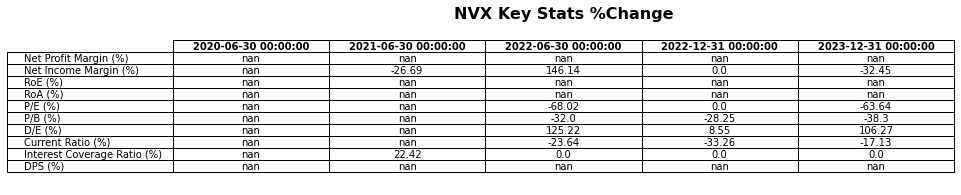

In [47]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(14, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=interested_ticker_key_interested_stats_pct_change.T.values,
                 colLabels=interested_ticker_key_interested_stats_pct_change.T.columns,
                 rowLabels=interested_ticker_key_interested_stats_pct_change.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Stats %Change", fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_interested_ticker_key_interested_stats_pct_change.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [48]:
raw_stats_dict = dict()
object_dict = dict()

for ticker in comparable_tickers['list']:
    ticker = ticker.split('.')[0]
    print('\n', ticker)
    raw_stats, key_interested_stats, key_interested_stats_pct_change, object = get_fundemental_dfs(
        first_end_of_quarter, historical_prices, ticker)

    raw_stats_dict[ticker] = raw_stats
    object_dict[ticker] = object


 AIA

 AIZ

 ALQ

 ALX

 ASB

 AZJ
Interest Paid Supplemental Data not found for ticker AZJ: 'Interest Paid Supplemental Data'
Missing data for Net Profit for ticker AZJ: 'Interest Paid Supplemental Data'
Missing data for Interest Coverage Ratio for ticker AZJ: 'Interest Paid Supplemental Data'

 BXB

 CWY

 DBI

 DOW

 FRW

 IFT

 IMD

 IPH

 JLG

 KLS

 MAD

 MGH

 MMS

 MND

 NWH

 QAN

 QUB

 REH

 RWC
Interest Paid Supplemental Data not found for ticker RWC: 'Interest Paid Supplemental Data'
Missing data for Net Profit for ticker RWC: 'Interest Paid Supplemental Data'
Missing data for Interest Coverage Ratio for ticker RWC: 'Interest Paid Supplemental Data'

 SIQ

 SVW

 TCL

 VNT


In [49]:
interpolated_financial_stats_dict = {}
for key in raw_stats_dict.keys():
    interpolated_financial_stats = interpolate_financial_stats(
        raw_stats_dict, key)
    interpolated_financial_stats_dict[key] = interpolated_financial_stats

In [50]:
interested_dates = [pd.to_datetime(
    dt.strftime('%Y-%m')) for dt in interested_ticker_key_interested_stats_pct_change.index]

In [51]:
agg_interpolated_financial_stats_df_dict = {}
for key in interpolated_financial_stats_dict:
    agg_interpolated_financial_stats_df = agg_interpolated_financial_stats(
        interpolated_financial_stats_dict[key], interested_dates)
    agg_interpolated_financial_stats_df_dict[key] = agg_interpolated_financial_stats_df

In [52]:
key_interested_stats_dict = {}
key_interested_stats_pct_change_dict = {}

for key in agg_interpolated_financial_stats_df_dict:
    stock_fundementals = process_stock_fundementals(
        agg_interpolated_financial_stats_df_dict[key], object_dict[key], first_end_of_quarter, historical_prices, key)

    key_interested_stats = get_key_interested_stats(stock_fundementals)

    key_interested_stats_pct_change = get_key_interested_stat_pct_change(
        key_interested_stats
    )

    key_interested_stats_dict[key] = key_interested_stats
    key_interested_stats_pct_change_dict[key] = key_interested_stats_pct_change

Missing data for Net Profit for ticker AZJ: 'Interest Paid Supplemental Data'
Missing data for Interest Coverage Ratio for ticker AZJ: 'Interest Paid Supplemental Data'
Missing data for Net Profit for ticker RWC: 'Interest Paid Supplemental Data'
Missing data for Interest Coverage Ratio for ticker RWC: 'Interest Paid Supplemental Data'


In [58]:
weighted_GICS_key_interested_stats = get_weighted_financials(
    key_interested_stats_dict, same_gics_industry_weight_dict)

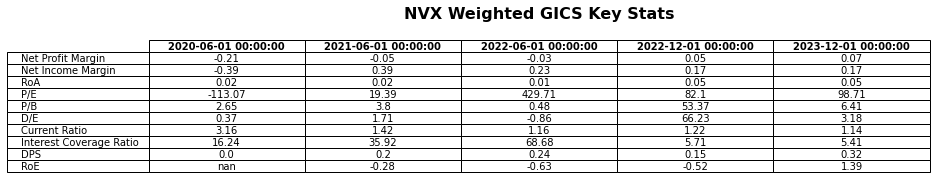

In [59]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(14, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=weighted_GICS_key_interested_stats.T.values,
                 colLabels=weighted_GICS_key_interested_stats.T.columns,
                 rowLabels=weighted_GICS_key_interested_stats.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Weighted GICS Key Stats",
          fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_weighted_GICS_key_interested_stats.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [60]:
weighted_GICS_key_interested_stats

,Net Profit Margin,Net Income Margin,RoA,P/E,P/B,D/E,Current Ratio,Interest Coverage Ratio,DPS,RoE
2020-06-01,-0.21,-0.39,0.02,-113.07,2.65,0.37,3.16,16.24,0.00,NaN
2021-06-01,-0.05,0.39,0.02,19.39,3.80,1.71,1.42,35.92,0.20,-0.28
2022-06-01,-0.03,0.23,0.01,429.71,0.48,-0.86,1.16,68.68,0.24,-0.63
2022-12-01,0.05,0.17,0.05,82.10,53.37,66.23,1.22,5.71,0.15,-0.52
2023-12-01,0.07,0.17,0.05,98.71,6.41,3.18,1.14,5.41,0.32,1.39


In [62]:
# can delete
interested_ticker_key_interested_stats

,Net Profit Margin,Net Income Margin,RoE,RoA,P/E,P/B,D/E,Current Ratio,Interest Coverage Ratio,DPS
2020-06-30,NaN,-4.71,NaN,NaN,NaN,NaN,NaN,NaN,-47.72,NaN
2021-06-30,NaN,-3.45,NaN,NaN,-66.80,6.49,0.07,26.92,-58.41,0.0
2022-06-30,NaN,-8.50,NaN,NaN,-21.36,4.41,0.17,20.56,NaN,0.0
2022-12-31,NaN,NaN,NaN,NaN,NaN,3.17,0.18,13.72,NaN,0.0
2023-12-31,NaN,-5.74,NaN,NaN,-7.77,1.95,0.38,11.37,NaN,0.0


In [53]:
weighted_GICS_key_interested_stats_pct_change = get_weighted_financials(
    key_interested_stats_pct_change_dict, same_gics_industry_weight_dict)

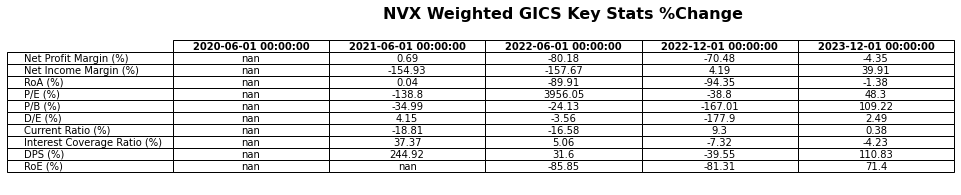

In [54]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(14, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=weighted_GICS_key_interested_stats_pct_change.T.values,
                 colLabels=weighted_GICS_key_interested_stats_pct_change.T.columns,
                 rowLabels=weighted_GICS_key_interested_stats_pct_change.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Weighted GICS Key Stats %Change",
          fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_weighted_GICS_key_interested_stats_pct_change.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [55]:
weighted_GICS_key_interested_stats_pct_change

,Net Profit Margin (%),Net Income Margin (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%),RoE (%)
2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,0.69,-154.93,0.04,-138.80,-34.99,4.15,-18.81,37.37,244.92,NaN
2022-06-01,-80.18,-157.67,-89.91,3956.05,-24.13,-3.56,-16.58,5.06,31.60,-85.85
2022-12-01,-70.48,4.19,-94.35,-38.80,-167.01,-177.90,9.30,-7.32,-39.55,-81.31
2023-12-01,-4.35,39.91,-1.38,48.30,109.22,2.49,0.38,-4.23,110.83,71.40


In [56]:
# can remove
interested_ticker_key_interested_stats_pct_change

,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,-26.69,NaN,NaN,NaN,NaN,NaN,NaN,22.42,NaN
2022-06-30,NaN,146.14,NaN,NaN,-68.02,-32.00,125.22,-23.64,0.00,NaN
2022-12-31,NaN,0.00,NaN,NaN,0.00,-28.25,8.55,-33.26,0.00,NaN
2023-12-31,NaN,-32.45,NaN,NaN,-63.64,-38.30,106.27,-17.13,0.00,NaN
